In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ftplib
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Read in csv from NOAA ftp server:

Citation: <br>
Burtner, Ashley; Palladino, Danna; Kitchens, Christine; Fyffe, Deanna; Johengen, Tom; Stuart, Dack; Cooperative Institute for Great Lakes Research, University of Michigan; Fanslow, David; Gossiaux, Duane; National Oceanic and Atmospheric Administration; Great Lakes Environmental Research Laboratory (2019). Physical, chemical, and biological water quality data collected from a small boat in western Lake Erie, Great Lakes from 2012-05-15 to 2018-10-09 (NCEI Accession 0187718). NOAA National Centers for Environmental Information. Dataset. https://accession.nodc.noaa.gov/0187718. Accessed 06-14-2020.

In [2]:
ftp = ftplib.FTP("ftp.nodc.noaa.gov")
ftp.login()
ftp.cwd("nodc/archive/arc0135/0187718/2.2/data/0-data/")
ftp.nlst()
download_file = io.BytesIO()
ftp.retrbinary('RETR lake_erie_habs_field_sampling_results_2012_2018_v2.csv', download_file.write)
download_file.seek(0)
data = pd.read_csv(download_file, engine='python', encoding = "ISO-8859-1")
ftp.quit()

'221 Goodbye.'

List exogenous variables to use in model. These are all physical/chemical properties of the water sample.
Endogenous variable is Particulate Microcystin (µg/L). This is the measure of the algae toxins contained.

In [3]:
columns = [
    'Particulate Microcystin (µg/L)',
    'Extracted Phycocyanin (µg/L)',
    'Extracted Chlorophyll a (µg/L)',
    'CTD Dissolved Oxygen (mg/L)',
    'CTD Specific Conductivity (µS/cm)',
    'CTD Photosynthetically Active Radiation (µE/m2/s)',
    'CTD Temperature (°C)',
    'CTD Tramission (%)',
    'CTD Beam Attenuation (m-1)',
    'Ammonia (µg N/L)',
    'Soluble Reactive Phosphorus (µg P/L)',
    'Nitrate + Nitrite (mg N/L)',
    'Total Dissolved Phosphorus (µg P/L)',
    'Particulate Organic Carbon (mg/L)',
    'Total Phosphorus (µg P/L)',
    'Particulate Organic Nitrogen (mg/L)',
    'Volatile Suspended Solids (mg/L)',
    'Total Suspended Solids (mg/L)'
]

Cast null values where values are blank or 'nd'.

In [4]:
for column in columns:
    if ' ' in data[column].unique() or 'nd' in data[column].unique():
        data.loc[data[column].isin([' ', 'nd']), column] = np.nan
        try:
            data[column] = data[column].astype('float64')
        except:
            pass

/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


List columns that have < in their values.

In [5]:
for column in columns:
    if data[column].dtype != 'float64':
        print(column)
        print(data.loc[data[column].str.contains("<").fillna(False), column].unique())

Particulate Microcystin (µg/L)
['<0.1']
Extracted Phycocyanin (µg/L)
['<0.036' '<0.06' '<0.36' '<0.9' '<0.45' '<1.8' '<0.6' '<40' '<0.03']
Ammonia (µg N/L)
['<0.04' '<0.4']
Soluble Reactive Phosphorus (µg P/L)
['<0.25']
Nitrate + Nitrite (mg N/L)
['<0.002']


Define functions to either replace "<x" values with zeros or with the value without the "<".

In [6]:
def zero_less_thans(df, column, zero_thres):
    df.loc[df[column] == zero_thres, column] = 0

In [7]:
def fill_less_thans(df, column):
    df.loc[df[column].str.contains("<").fillna(False), column] = df.loc[df[column].str.contains("<").fillna(False), column].str.replace("<", "")

For all columns containing "<x" value, replace the smallest "<x" value with zero, and replace others with x, <br>
except 'Ammonia (µg N/L)', since '<0.4' is probably a transcription error of '0.04' so replace both with zeros.

In [8]:
zero_less_thans(data, 'Particulate Microcystin (µg/L)', '<0.1')
zero_less_thans(data, 'Extracted Phycocyanin (µg/L)', '<0.03')
zero_less_thans(data, 'Ammonia (µg N/L)', '<0.04')
zero_less_thans(data, 'Ammonia (µg N/L)', '<0.4')
zero_less_thans(data, 'Soluble Reactive Phosphorus (µg P/L)', '<0.25')
zero_less_thans(data, 'Nitrate + Nitrite (mg N/L)', '<0.002')

fill_less_thans(data, 'Extracted Phycocyanin (µg/L)')

Drop row with anomalous and inconsistent Particulate Microcystin measurement.

In [9]:
data.drop(data[data['Particulate Microcystin (µg/L)'] == '2778.75 ± 294'].index, inplace = True)

Cast all columns of interest as type float.

In [10]:
for column in columns:
    if data[column].dtype != 'float64':
        try:
            data[column] = data[column].astype('float64')
        except:
            print(column)

Make time series of observations at site WE2.

In [11]:
ts = data[data['Site'] == 'WE2'].copy().drop_duplicates(subset = 'Date')

ts.set_index(pd.to_datetime(ts['Date']), inplace = True)

ts = ts.loc[ts['Site'] == 'WE2'][columns].interpolate(method = 'time').dropna()

Resample and interpolate to force weekly frequency on time series.

In [12]:
ts = ts.resample('W').mean().interpolate(method = 'time')

Time series plot of target variable. Last 52 weeks will be excluded from the training data and used to assess performance of models.

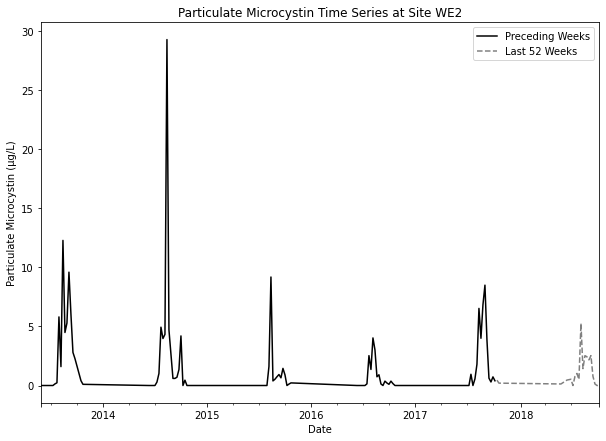

In [13]:
plt.figure(figsize = (10, 7))
ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52).plot(color = 'k', label = 'Preceding Weeks')
ts['Particulate Microcystin (µg/L)'].tail(52).plot(color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
plt.title('Particulate Microcystin Time Series at Site WE2')
plt.legend();
plt.ylabel('Particulate Microcystin (µg/L)')
plt.savefig('images/TimeSeries.jpg')

Data is extremely seasonal. Examine seasonal decomposition of target variable: <br>
We see that there is a spike in Particulate Microcystin during summer of each year, and that 2014 and 2015 were the most extreme years. The seasonal component is an order of magnitude larger than the trend component.

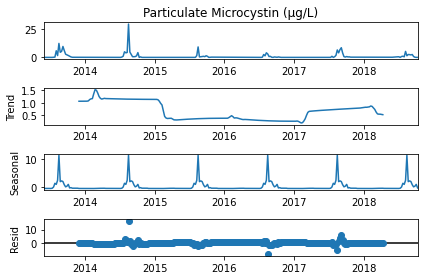

In [14]:
seasonal_decompose(ts['Particulate Microcystin (µg/L)']).plot()
plt.savefig('images/Seasonal.jpg')

Compare seasonality of target variable to seasonalities of all other variables.

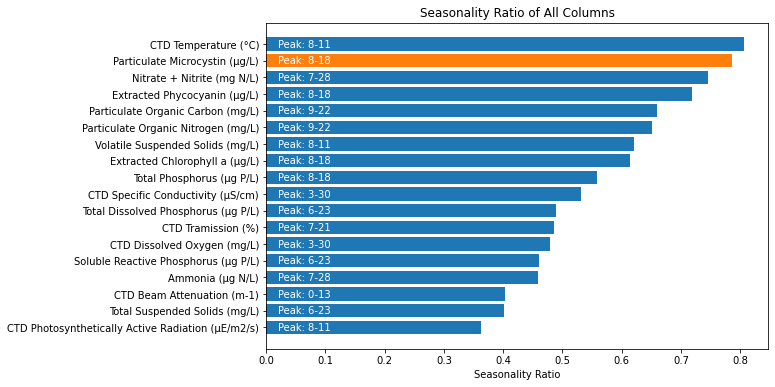

In [15]:
seasonalities = {
    'Column': [],
    'Seasonality': []
}
for column in ts.columns:
    seasonalities['Column'].append(column)
    seasonalities['Seasonality'].append(seasonal_decompose(ts[column]).seasonal.std() / ts[column].std())

seasonalities_df = pd.DataFrame(seasonalities).sort_values(by = 'Seasonality', ascending = True)

plt.figure(figsize = (9,6))
plt.barh(
    y = seasonalities_df['Column'],
    width = seasonalities_df['Seasonality']
)
plt.barh(
    y = 'Particulate Microcystin (µg/L)',
    width = seasonalities_df.loc[seasonalities_df['Column'] == 'Particulate Microcystin (µg/L)', 'Seasonality']
)
plt.xlabel("Seasonality Ratio")
plt.title("Seasonality Ratio of All Columns")
for column in seasonalities_df['Column']:
    plt.text(x = 0.02,
            y = column,
            s = f"Peak: {seasonal_decompose(ts[column]).seasonal.idxmax().isoformat()[6:10]}",
            verticalalignment = 'center',
            color = 'w')
plt.savefig('images/Seasonality.jpg')

Plot the auto correlation lags and partial autocorrelation lags for the target variable. We can see that lags of 1, 2, 3, 49, and 52 are significantly correlated with the target variable at lag 0; i.e. the values from a couple weeks ago and the values from about a year ago can be used to predict the values of this week.

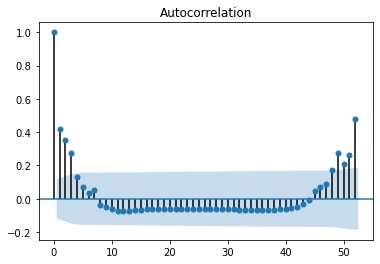

In [16]:
plot_acf(ts['Particulate Microcystin (µg/L)'], lags = 52);
plt.savefig('images/ACF.jpg')

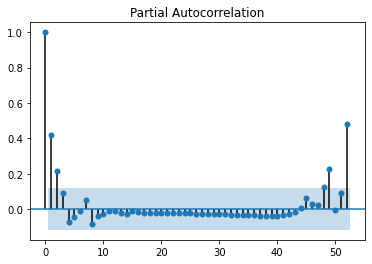

In [17]:
plot_pacf(ts['Particulate Microcystin (µg/L)'], lags = 52);
plt.savefig('images/PACF.jpg')

There appears to be no long-term trends in the target variable, and the low p-value of the Augmented Dickey-Fuller Test provided additional evidence that the data can be considered stationary.

In [18]:
pd.DataFrame(adfuller(ts['Particulate Microcystin (µg/L)'])[0:2], index=['Test Statistic','p-value'])

,0
Test Statistic,-7.191639e+00
p-value,2.494817e-10


Create autoregressed time series based on significant lags from partial autocorrelation function.

In [19]:
def auto_regress_lags(df):
    return pd.concat([
        df, 
        df.shift(1).rename(columns = {df.columns[0]: 'Lag_1'}),
        df.shift(2).rename(columns = {df.columns[0]: 'Lag_2'}),
        df.shift(3).rename(columns = {df.columns[0]: 'Lag_3'}),
        df.shift(49).rename(columns = {df.columns[0]: 'Lag_49'}),
        df.shift(52).rename(columns = {df.columns[0]: 'Lag_52'}),
              ], axis = 1).dropna()

In [20]:
ar_ts = auto_regress_lags(ts[['Particulate Microcystin (µg/L)']])

In [21]:
X_train = ar_ts.drop(columns = ['Particulate Microcystin (µg/L)']).head(ar_ts.shape[0] - 52)
y_train = ar_ts['Particulate Microcystin (µg/L)'].head(ar_ts.shape[0] - 52)
X_test = ar_ts.drop(columns = ['Particulate Microcystin (µg/L)']).tail(52)
y_test = ar_ts['Particulate Microcystin (µg/L)'].tail(52)

Fit linear model on lagged data, plot predictions against actual values.

In [22]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
ar_model = sm.OLS(y_train, X_train).fit()
ar_preds = ar_model.predict(X_test)

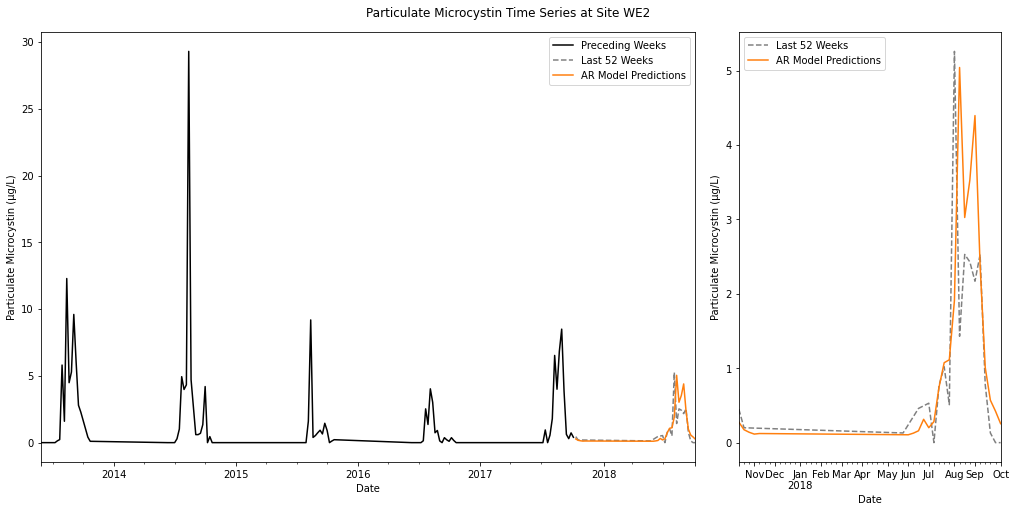

In [23]:
fig = plt.figure(figsize = (14, 7), constrained_layout=True)
spec5 = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[5, 2], height_ratios=[1])
ax1 = fig.add_subplot(spec5[0, 1])
ax0 = fig.add_subplot(spec5[0, 0])
ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52).plot(ax = ax0, color = 'k', label = 'Preceding Weeks')
for ax in [ax0, ax1]:
    ts['Particulate Microcystin (µg/L)'].tail(52).plot(ax = ax, color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
    ar_preds.plot(ax = ax, color = 'tab:orange', label = 'AR Model Predictions')
    ax.set_ylabel('Particulate Microcystin (µg/L)');
    ax.legend();
plt.suptitle('Particulate Microcystin Time Series at Site WE2');
plt.savefig('images/TimeSeriesAR.jpg')

Root mean squared error for the last 52 weeks for the autoregressive model:

In [24]:
mean_squared_error(y_test, ar_model.predict(X_test)) ** 0.5

0.7848867576503165

Generate training and testing datasets for Principal Component Analysis. PCA to be peformed on other water properties exclusing target variable.

In [25]:
X_train = ts.drop(columns = ['Particulate Microcystin (µg/L)']).head(ts.shape[0] - 52)
y_train = ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52)
X_test = ts.drop(columns = ['Particulate Microcystin (µg/L)']).tail(52)
y_test = ts['Particulate Microcystin (µg/L)'].tail(52)

ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(ss.fit_transform(X_test), columns = X_test.columns, index = X_test.index)

Perform PCA on training data, plot explained variance for each PC.

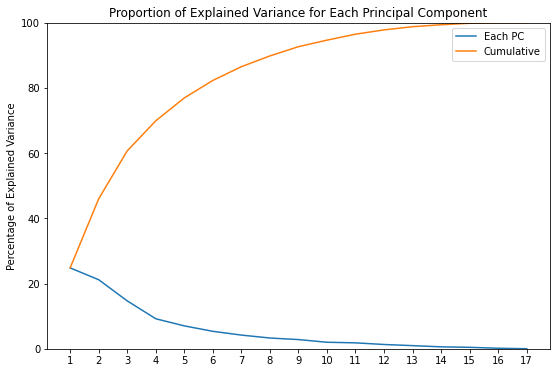

In [26]:
pca = PCA(random_state = 26)
pca.fit(X_train)
plt.figure(figsize = (9,6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), 100 * pca.explained_variance_ratio_, label = 'Each PC')
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(100 * pca.explained_variance_ratio_), label = 'Cumulative')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.title("Proportion of Explained Variance for Each Principal Component")
plt.ylabel("Percentage of Explained Variance")
plt.legend()
plt.ylim(0,100);

Create dataframe of principal components.

In [27]:
pca_df_train = pd.DataFrame(pca.transform(X_train), columns = [f'PC{i + 1}' for i in range(len(pca.explained_variance_ratio_))], index = X_train.index)[[f'PC{i + 1}' for i in range(5)]]
pca_df_test = pd.DataFrame(pca.transform(X_test), columns = [f'PC{i + 1}' for i in range(len(pca.explained_variance_ratio_))], index = X_test.index)[[f'PC{i + 1}' for i in range(5)]]

Perform AR model using same lags as target variable AR model on each principal component.

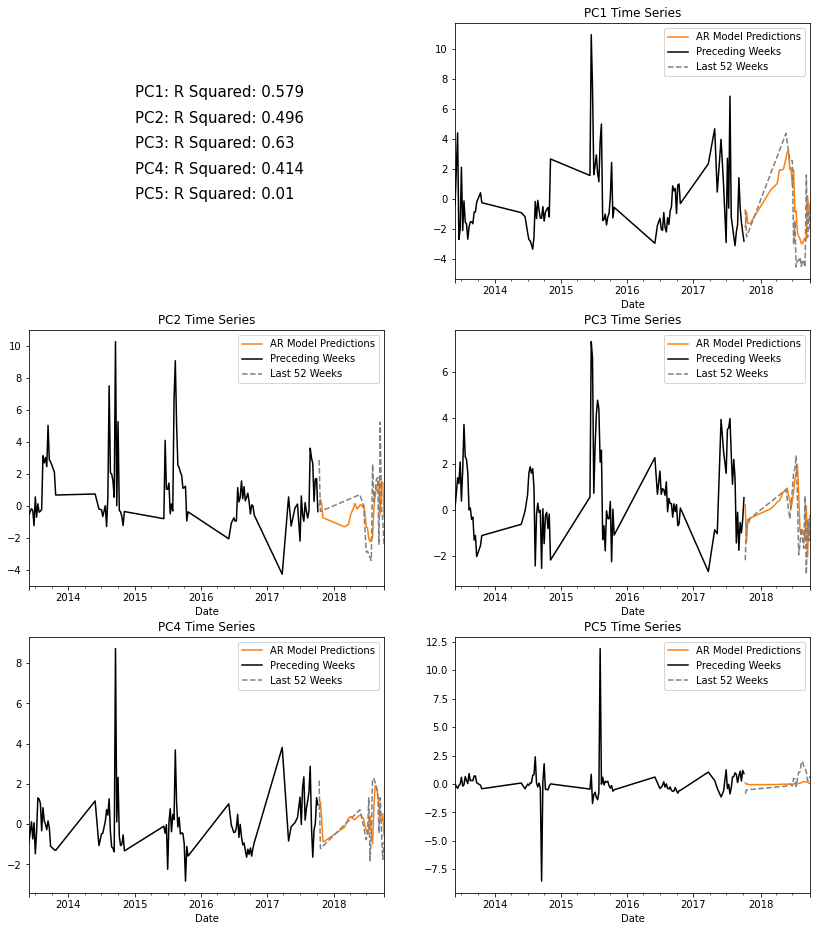

In [28]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (14,16))
ax = ax.ravel()
for i in range(1, 6):
    
    pca_ar = auto_regress_lags(pd.concat([pca_df_train, pca_df_test])[[f'PC{i}']])
    pca_ar_X_train = pca_ar.drop(columns = [f'PC{i}']).head(ar_ts.shape[0] - 52)
    pca_ar_y_train = pca_ar[f'PC{i}'].head(ar_ts.shape[0] - 52)
    pca_ar_X_test = pca_ar.drop(columns = [f'PC{i}']).tail(52)
    pca_ar_y_test = pca_ar[f'PC{i}'].tail(52)
    pca_ar_X_train = sm.add_constant(pca_ar_X_train)
    pca_ar_X_test = sm.add_constant(pca_ar_X_test)
    pca_ar_model = sm.OLS(pca_ar_y_train, pca_ar_X_train).fit()
    pca_ar_model.predict(pca_ar_X_test).plot(ax = ax[i], color = 'tab:orange', label = 'AR Model Predictions')
    
    if i == 1:
        lr_X_test = pca_ar_model.predict(pca_ar_X_test)
    else:
        lr_X_test = pd.concat([lr_X_test, pca_ar_model.predict(pca_ar_X_test)], axis = 1)
    
    pca_df_train[f'PC{i}'].plot(ax = ax[i], color = 'k', label = 'Preceding Weeks')
    pca_df_test[f'PC{i}'].plot(ax = ax[i], color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
    ax[i].legend()
    ax[i].set_title(f'PC{i} Time Series')
    ax[0].text(0.3, 
               0.8 - 0.1 * i,
               f'PC{i}: R Squared: {round(pca_ar_model.rsquared, 3)}',
               verticalalignment='bottom',
               horizontalalignment='left',
               color='k', 
               fontsize=15);
    
ax[0].axis('off');
plt.savefig('images/PCs.jpg')

Perform linear regression of target variable against 1st four principal components of endogenous variables.

In [29]:
lr_X_train = pca_df_train.copy()
lr_X_test.columns = lr_X_train.columns
lr_X_train = sm.add_constant(lr_X_train)
lr_X_test = sm.add_constant(lr_X_test)
lr_model = sm.OLS(y_train, lr_X_train).fit()
lr_preds = lr_model.predict(lr_X_test)

Plot predictions of linear PCA model vs AR model:

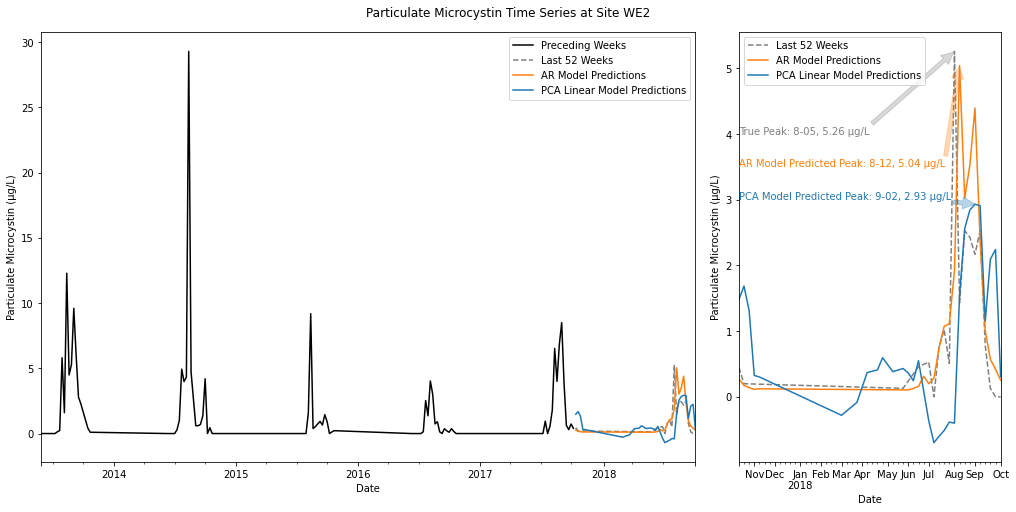

In [30]:
fig = plt.figure(figsize = (14, 7), constrained_layout=True)
spec5 = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[5, 2], height_ratios=[1])
ax1 = fig.add_subplot(spec5[0, 1])
ax0 = fig.add_subplot(spec5[0, 0])
ts['Particulate Microcystin (µg/L)'].head(ts.shape[0] - 52).plot(ax = ax0, color = 'k', label = 'Preceding Weeks')
for ax in [ax0, ax1]:
    ts['Particulate Microcystin (µg/L)'].tail(52).plot(ax = ax, color = 'gray', linestyle = '--', label = 'Last 52 Weeks')
    ar_preds.plot(ax = ax, color = 'tab:orange', label = 'AR Model Predictions')
    lr_preds.plot(ax = ax, color = 'tab:blue', label = 'PCA Linear Model Predictions')
    ax.set_ylabel('Particulate Microcystin (µg/L)');
    ax.legend();
plt.suptitle('Particulate Microcystin Time Series at Site WE2')
for s, t, h, c in zip(
    [
        ts['Particulate Microcystin (µg/L)'].tail(52),
        ar_preds,
        lr_preds
    ],
    [
        'True Peak',
        'AR Model Predicted Peak',
        'PCA Model Predicted Peak',
    ],
    [
        4,
        3.5,
        3,
    ],
    [
        'grey',
        'tab:orange',
        'tab:blue'
    ]
):
    ax1.annotate(f"{t}: {s.idxmax().isoformat()[6:10]}, {round(s.max(),2)} µg/L", 
                 xy = (
                     s.tail(52).idxmax(), 
                     s.tail(52).max()
                 ), 
                 xytext = (
                     s.tail(52).head(1).index[0], 
                     h
                 ),
                 color = c,
                arrowprops = dict(facecolor = c, shrink=0.01, edgecolor = c, alpha = 0.3));
plt.savefig('images/TimeSeriesARPCA.jpg')

Root mean squared error for the last 52 weeks for the linear PCA model:

In [31]:
mean_squared_error(y_test, lr_preds) ** 0.5

1.029277924703288